<h2 align=center>Generate Synthetic Images with DCGANs</h2>

Project Overview and Import Libraries

In [13]:
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

In [14]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

## Hyperparameters

In [15]:
latent_size = 100
img_size = 64
batch_size = 64
lr = 0.0002
b1 = 0.5
b2 = 0.999
n_epochs = 25

## Define the generator network

In [16]:

class Generator(nn.Module):
    def __init__(self, latent_size, img_size):
        super(Generator, self).__init__()
        self.img_size = img_size # Added img_size as needed in forward method
        self.fc = nn.Linear(latent_size, 128 * (img_size // 4) ** 2)
        self.conv = nn.Sequential(
            nn.BatchNorm2d(128),
            nn.Upsample(scale_factor=2),
            nn.Conv2d(128, 128, 3, stride=1, padding=1),
            nn.BatchNorm2d(128, 0.8),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Upsample(scale_factor=2),
            nn.Conv2d(128, 64, 3, stride=1, padding=1),
            nn.BatchNorm2d(64, 0.8),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64, 3, 3, stride=1, padding=1),
            nn.Tanh()
        )

    def forward(self, z):
        out = self.fc(z)
        out = out.view(out.shape[0], 128, (self.img_size // 4), (self.img_size // 4))
        img = self.conv(out)
        return img


## Define the discriminator network

In [17]:
class Discriminator(nn.Module):
    def __init__(self, img_size):
        super(Discriminator, self).__init__()

        self.model = nn.Sequential(
            # Changed all kernel sizes from 3 to 4
            nn.Conv2d(3, 64, 4, stride=2, padding=1), #changed image size from 32 to 64
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout2d(0.25),
            nn.Conv2d(64, 64*2, 4, stride=2, padding=1), #changed 64 to 64*2
            nn.ZeroPad2d((0, 1, 0, 1)),
            nn.BatchNorm2d(64*2, 0.8), #changed 64 to 64*2
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout2d(0.25),
            nn.Conv2d(64*2, 128*2, 4, stride=2, padding=1), #changed 64 to 64*2 and 128 to 128*2
            nn.BatchNorm2d(128*2, 0.8), #changed 128 to 128*2
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout2d(0.25),
            nn.Conv2d(64*4, 64*8, 4, stride=2, padding=1), # No existence. Added to solve issues
            nn.BatchNorm2d(512, 0.8), # No existence. Added to solve issues
            nn.LeakyReLU(0.2, inplace=True), # No existence. Added to solve issues
            nn.Conv2d(512, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, img):
        validity = self.model(img)
        return validity

In [18]:
# Use GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


## Initialize generator and discriminator

In [19]:
generator = Generator(latent_size, img_size).to(device)
discriminator = Discriminator(img_size).to(device)

## Optimizers

In [20]:
optimizer_G = optim.Adam(generator.parameters(), lr=lr, betas=(b1, b2))
optimizer_D = optim.Adam(discriminator.parameters(), lr=lr, betas=(b1, b2))

## Binary Cross-Entropy loss function

In [21]:
adversarial_loss = nn.BCELoss()

## Generate random noise

In [22]:
fixed_noise = torch.randn(64, latent_size, device=device)

## Load and Preprocess data

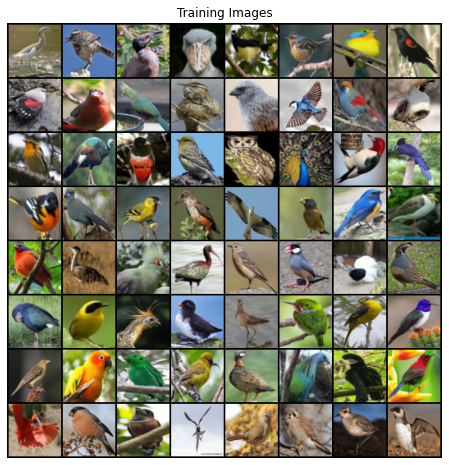

In [23]:
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils

# Root directory for dataset
dataroot = "datasets/birds/train"

# We can use an image folder dataset the way we have it setup.
# Create the dataset
dataset = dset.ImageFolder(root=dataroot,
                           transform=transforms.Compose([
                               transforms.Resize(img_size),
                               transforms.CenterCrop(img_size),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                           ]))
# Create the dataloader
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                         shuffle=True, num_workers=2)

# Plot some training images
real_batch = next(iter(dataloader))
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)))

## Training loop

In [24]:

for epoch in range(n_epochs):
    for i, (imgs, _) in enumerate(dataloader):
            # Move data to GPU
        real_imgs = imgs.to(device)
        batch_size = real_imgs.size(0)

        # Train the discriminator
        optimizer_D.zero_grad()

        # Real images
        validity_real = discriminator(real_imgs).view(-1) # included transformation with view(-1) 
        d_loss_real = adversarial_loss(validity_real, torch.ones(batch_size, device=device))
        d_loss_real.backward()

        # Fake images
        z = torch.randn(batch_size, latent_size, device=device)
        fake_imgs = generator(z)
        validity_fake = discriminator(fake_imgs.detach()).view(-1) # included transformation with view(-1) 
        d_loss_fake = adversarial_loss(validity_fake, torch.zeros(batch_size, device=device))
        d_loss_fake.backward()

        d_loss = d_loss_real + d_loss_fake
        optimizer_D.step()

        # Train the generator
        optimizer_G.zero_grad()

        z = torch.randn(batch_size, latent_size, device=device)
        fake_imgs = generator(z)
        validity = discriminator(fake_imgs).view(-1) # included transformation with view(-1) 
        g_loss = adversarial_loss(validity, torch.ones(batch_size, device=device))
        g_loss.backward()
        optimizer_G.step()

        if i % 500 == 0:
            print(f"[Epoch {epoch}/{n_epochs}] [Batch {i}/{len(dataloader)}] [D loss: {d_loss.item()}] [G loss: {g_loss.item()}]")

# Generate and save samples after each epoch
    with torch.no_grad(): # adjusted tabulation
        fake_imgs = generator(fixed_noise)
        vutils.save_image(fake_imgs.cpu(), f"images/{epoch}.png")


[Epoch 0/25] [Batch 0/1104] [D loss: 1.385412573814392] [G loss: 0.6862597465515137]
[Epoch 0/25] [Batch 500/1104] [D loss: 1.454958438873291] [G loss: 0.8468250036239624]
[Epoch 0/25] [Batch 1000/1104] [D loss: 1.030641794204712] [G loss: 1.2740459442138672]
[Epoch 1/25] [Batch 0/1104] [D loss: 1.734060525894165] [G loss: 1.8789221048355103]
[Epoch 1/25] [Batch 500/1104] [D loss: 0.8159285187721252] [G loss: 1.4400525093078613]
[Epoch 1/25] [Batch 1000/1104] [D loss: 0.4964054822921753] [G loss: 2.8072283267974854]
[Epoch 2/25] [Batch 0/1104] [D loss: 0.9573136568069458] [G loss: 4.948449611663818]
[Epoch 2/25] [Batch 500/1104] [D loss: 1.6132264137268066] [G loss: 4.471700668334961]
[Epoch 2/25] [Batch 1000/1104] [D loss: 0.7363089919090271] [G loss: 4.761658668518066]
[Epoch 3/25] [Batch 0/1104] [D loss: 0.33153465390205383] [G loss: 3.294778823852539]
[Epoch 3/25] [Batch 500/1104] [D loss: 0.28839537501335144] [G loss: 4.89070463180542]
[Epoch 3/25] [Batch 1000/1104] [D loss: 0.248

## Images Comparison

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


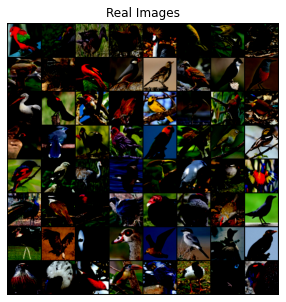

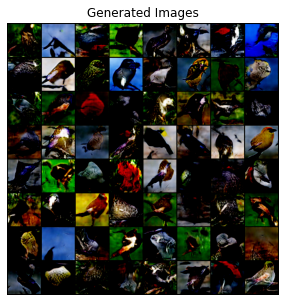

In [25]:
# Plot real and fake images
real_images = next(iter(dataloader))[0][:64]
with torch.no_grad():
    fake_images = generator(torch.randn(64, latent_size, device=device))
    
grid_real = vutils.make_grid(real_images, padding=2) # no call for vutils
grid_fake = vutils.make_grid(fake_images, padding=2) # no call for vutils

plt.figure(figsize=(15,5))
plt.imshow(np.transpose(grid_real.numpy(), (1, 2, 0)))
plt.axis("off")
plt.title("Real Images")

plt.figure(figsize=(15,5))
plt.imshow(np.transpose(grid_fake.cpu().numpy(), (1, 2, 0)))
plt.axis("off")
plt.title("Generated Images")

plt.show()

## Compute MSE

In [27]:
# Compute mean squared error
mse = nn.MSELoss()
with torch.no_grad():
    loss = mse(real_images.cpu(), fake_images.cpu())
print(f"MSE: {loss.item()}")

MSE: 0.39263078570365906


## Compute SSIM

In [30]:
# Compute structural similarity index
'''ssim = torch.ssim.SSIM(window_size=11)
with torch.no_grad():
    ssim_loss = 1 - ssim(real_images, fake_images).mean()
print(f"SSIM: {ssim_loss.item()}")'''


'ssim = torch.ssim.SSIM(window_size=11)\nwith torch.no_grad():\n    ssim_loss = 1 - ssim(real_images, fake_images).mean()\nprint(f"SSIM: {ssim_loss.item()}")'

## Create a gif of the evolution
This section was not included

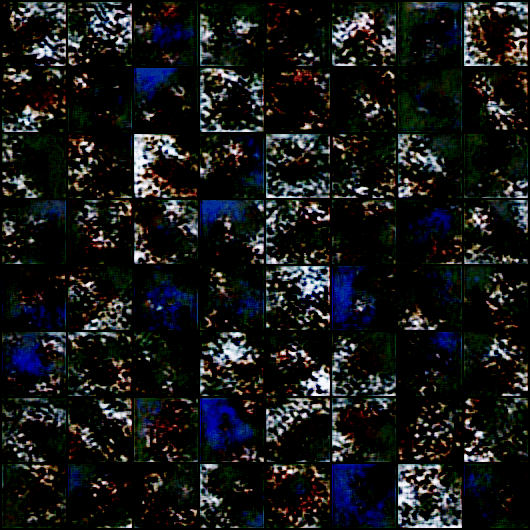

In [29]:
import imageio
import glob

anim_file = 'chatgpt_bird_generation.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
  filenames = glob.glob('images/*.png')
  filenames = sorted(filenames)
  last = -1
  for i,filename in enumerate(filenames):
    frame = 2*(i)
    if round(frame) > round(last):
      last = frame
    else:
      continue
    image = imageio.imread(filename)
    writer.append_data(image)
  image = imageio.imread(filename)
  writer.append_data(image)

from IPython import display
display.Image(filename=anim_file)

In [35]:
noise = torch.randn(1, latent_size, device=device)
input_names = ["Noise"]
output_names = ["ChatGPT Generated Bird"]
onnxModel = generator.eval()
torch.onnx.export(onnxModel, noise, "chatGPT_genModel.onnx", input_names=input_names, output_names=output_names)
input_names = ["Bird Image"]
output_names = ["ChatGPT Classification"]
fake = generator(noise).detach()
onnxModel = discriminator.eval()
torch.onnx.export(onnxModel, fake.detach(), "chatGPT_disModel.onnx", input_names=input_names, output_names=output_names)